# Plot Ground Truth

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from copy import deepcopy
from typing import Tuple
import matplotlib.patches as patches
import os
import random

# Define the transformation functions
def get_preprocess_shape(oldh: int, oldw: int, long_side_length: int) -> Tuple[int, int]:
    """
    Compute the output size given input size and target long side length.
    """
    scale = long_side_length * 1.0 / max(oldh, oldw)
    newh, neww = oldh * scale, oldw * scale
    neww = int(neww + 0.5)
    newh = int(newh + 0.5)
    return (newh, neww)

def inverse_coords(coords: np.ndarray, original_size: Tuple[int, int], target_length=1024) -> np.ndarray:
    """
    Inverse transformation of coordinates from resized back to original.
    """
    old_h, old_w = original_size
    new_h, new_w = get_preprocess_shape(old_h, old_w, target_length)
    coords = deepcopy(coords).astype(float)
    coords[..., 0] = coords[..., 0] * (old_w / new_w)
    coords[..., 1] = coords[..., 1] * (old_h / new_h)
    return coords

def inverse_boxes(boxes: np.ndarray, original_size: Tuple[int, int], target_length=1024) -> np.ndarray:
    """
    Inverse transformation of boxes from resized back to original.
    """
    boxes = inverse_coords(boxes.reshape(-1, 2, 2), original_size, target_length)
    return boxes.reshape(-1, 4)

def convert_boxes(boxes):
    # Convert the boxes from center format to [y_min, x_min, y_max, x_max] format
    converted_boxes = np.zeros_like(boxes)
    converted_boxes[:, 0] = boxes[:, 1] - boxes[:, 3] / 2.0  # x_min
    converted_boxes[:, 1] = boxes[:, 0] - boxes[:, 2] / 2.0  # y_min
    converted_boxes[:, 2] = boxes[:, 1] + boxes[:, 3] / 2.0  # x_max
    converted_boxes[:, 3] = boxes[:, 0] + boxes[:, 2] / 2.0  # y_max
    return converted_boxes

def plot_bbox(image, original_boxes, title):
    # Plot the image with bounding boxes
    plt.imshow(image)
    ax = plt.gca()

    for box in original_boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.title(title)
    plt.show()


# Load SAM model and generate image embdding

In [2]:
cd /home/icb/hanyi.zhang/Detection_Head/segment-anything

/ictstr01/home/icb/hanyi.zhang/Detection_Head/segment-anything


/home/icb/hanyi.zhang/.local/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.separate_sam_encoder import SamEncoder
import torch

sam_checkpoint = "/home/icb/hanyi.zhang/Detection_Head/segment-anything/sam_vit_l_0b3195.pth"
model_type = "vit_l"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

sam_image_encoder = SamEncoder(sam, device)
predictor = SamPredictor(sam)

'''image_path = '/home/icb/hanyi.zhang/organoids_images/1709910822.png'
image_path = '/home/icb/hanyi.zhang/organoids_images/1709910835.png'
image_path = '/home/icb/hanyi.zhang/organoids_images/Picture2.png'
image_path = '/home/icb/hanyi.zhang/organoids_images/Picture3.png'

file_idx = image_path.rsplit('.', 1)[0]

image_embedding_path = image_path.replace('.png', '.npy')
# Load the image file and convert it to a numpy array
with Image.open(image_path) as image:
    image = image.convert('RGB')
    img_np = np.array(image)

# Process the image to get its embedding
img_embed = sam_image_encoder.set_image(img_np)
np.save(image_embedding_path, img_embed.cpu().detach().numpy())

original_size = image.size  # (width, height)
original_size = (original_size[1], original_size[0])  # Convert to (height, width)
original_size'''

"image_path = '/home/icb/hanyi.zhang/organoids_images/1709910822.png'\nimage_path = '/home/icb/hanyi.zhang/organoids_images/1709910835.png'\nimage_path = '/home/icb/hanyi.zhang/organoids_images/Picture2.png'\nimage_path = '/home/icb/hanyi.zhang/organoids_images/Picture3.png'\n\nfile_idx = image_path.rsplit('.', 1)[0]\n\nimage_embedding_path = image_path.replace('.png', '.npy')\n# Load the image file and convert it to a numpy array\nwith Image.open(image_path) as image:\n    image = image.convert('RGB')\n    img_np = np.array(image)\n\n# Process the image to get its embedding\nimg_embed = sam_image_encoder.set_image(img_np)\nnp.save(image_embedding_path, img_embed.cpu().detach().numpy())\n\noriginal_size = image.size  # (width, height)\noriginal_size = (original_size[1], original_size[0])  # Convert to (height, width)\noriginal_size"

# Load the Model Checkpoint and evaluate

In [4]:
cd /home/icb/hanyi.zhang/Detection_Head

/ictstr01/home/icb/hanyi.zhang/Detection_Head


/home/icb/hanyi.zhang/.local/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
# Load checkpoint here
import torch
from detection_head_model import DetectionHead

#checkpoint_path = '/home/icb/hanyi.zhang/Detection_Head/checkpoints/DetectionHead_training-original-epoch=299-val_loss=7.69.ckpt' 
checkpoint_path = '/home/icb/hanyi.zhang/Detection_Head/checkpoints/DetectionHead_training-smaller-patches-epoch=299-val_loss=9.22.ckpt'

model = DetectionHead.load_from_checkpoint(checkpoint_path)

# Set the model to evaluation mode
model.eval()

# Determine device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DetectionHead(
  (matcher): HungarianMatcher()
  (criterion): SetCriterion(
    (matcher): HungarianMatcher()
  )
  (query_embed): Embedding(100, 256)
  (position_embedding): PositionEmbeddingSine()
  (transformer_decoder): TransformerDecoder(
    (self_attention_layers): ModuleList(
      (0-5): 6 x SelfAttentionLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (cross_attention_layers): ModuleList(
      (0-5): 6 x CrossAttentionLayer(
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (ffn_layers): ModuleL

In [6]:
import os
import numpy as np
from PIL import Image
from sklearn.metrics import precision_recall_curve, average_precision_score
import json
import cv2
from scipy.optimize import linear_sum_assignment

# Function to load checkpoint and perform evaluation on one example
def evaluate_single_example(model, img_emb):
    # Prepare the input
    img_emb = torch.tensor(img_emb, dtype=torch.float32).to(device)  # Convert and move to GPU if available
    
    # Dummy query embedding (you may adjust this based on your actual implementation)
    query_embed = model.query_embed.weight.to(device)
    
    # Get positional embedding
    pos_embedding = model.position_embedding(img_emb)
    
    # Forward pass
    with torch.no_grad():
        outputs = model(query_embedding=query_embed, image_embedding=img_emb, pos_embedding=pos_embedding)

    # Apply softmax to pred_logits
    pred_logits = torch.nn.functional.softmax(outputs['pred_logits'][0], dim=-1)
    
    # Convert softmax output to binary predictions (0 or 1)
    binary_predictions = (pred_logits[:, 0] > pred_logits[:, 1]).cpu().numpy().astype(int)
    
    # Filter out boxes with binary prediction value 0
    pred_boxes = outputs['pred_boxes'].cpu().numpy()[0]
    filtered_boxes = pred_boxes[binary_predictions == 1]
    confidence_scores = pred_logits[binary_predictions == 1, 0].cpu().numpy()
    
    return filtered_boxes, confidence_scores

def non_max_suppression(bboxes, scores, threshold):
    """Perform Non-Maximum Suppression (NMS) on bounding boxes.
    
    Args:
    bboxes (numpy.ndarray): Array of bounding boxes in the format (x1, y1, x2, y2).
    scores (numpy.ndarray): Array of scores for each bounding box.
    threshold (float): IoU threshold for suppression.

    Returns:
    numpy.ndarray: Array of indices of bounding boxes to keep.
    """
    # Sort the bounding boxes by the scores in descending order
    indices = np.argsort(scores)[::-1]
    
    keep = []
    while len(indices) > 0:
        current = indices[0]
        keep.append(current)
        
        if len(indices) == 1:
            break
        
        current_box = bboxes[current]
        remaining_boxes = bboxes[indices[1:]]
        
        # Compute IoU of the current box with the rest
        ious = np.array([compute_iou(current_box, box) for box in remaining_boxes])
        
        # Select boxes with IoU less than the threshold
        indices = indices[1:][ious < threshold]
    
    return np.array(keep)

def compute_iou(box1, box2):
    x1_max = max(box1[0], box2[0])
    y1_max = max(box1[1], box2[1])
    x2_min = min(box1[2], box2[2])
    y2_min = min(box1[3], box2[3])

    intersection_area = max(0, x2_min - x1_max) * max(0, y2_min - y1_max)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - intersection_area

    if union_area == 0:
        return 0.0

    iou = intersection_area / union_area
    return iou

# Use Hungarian Matching
def evaluate_detections(gt_boxes, pred_boxes, confidence_scores, iou_threshold=0.5):
    num_gt = len(gt_boxes)
    num_pred = len(pred_boxes)
    
    iou_matrix = np.zeros((num_gt, num_pred))
    
    for i, gt_box in enumerate(gt_boxes):
        for j, pred_box in enumerate(pred_boxes):
            iou_matrix[i, j] = compute_iou(gt_box, pred_box)
    
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)
    
    matches = [(i, j) for i, j in zip(row_ind, col_ind) if iou_matrix[i, j] >= iou_threshold]
    
    matched_gt_indices = {gt_idx for gt_idx, _ in matches}
    matched_pred_indices = {pred_idx for _, pred_idx in matches}

    true_positives = len(matched_gt_indices)
    false_positives = len(pred_boxes) - len(matched_pred_indices)
    false_negatives = len(gt_boxes) - len(matched_gt_indices)
    
    iou_sum = sum(iou_matrix[gt_idx, pred_idx] for gt_idx, pred_idx in matches)
    average_iou = iou_sum / len(matches) if matches else 0
    
    if len(pred_boxes) != 0:
        y_true = [1 if i in matched_pred_indices else 0 for i in range(len(pred_boxes))]
        ap = average_precision_score(y_true, confidence_scores)
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    else:
        ap = 0
        precision = 0
    
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return {
        'average_iou': average_iou,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'ap': ap,
        'precision': precision,
        'recall': recall
    }

def calculate_seg_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0
    return intersection / union

def calculate_dice(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    return 2 * intersection / (mask1.sum() + mask2.sum())

def evaluate_segmentation(gt_masks, pred_masks, iou_threshold=0.5):
    # Get unique masks from ground truth
    unique_vals = np.unique(gt_masks)
    unique_vals = unique_vals[unique_vals != 0]  # Remove background value
    
    # Convert predicted masks to numpy arrays
    pred_masks_np = pred_masks.squeeze(1).detach().cpu().numpy()
    
    num_gt = len(unique_vals)
    num_pred = pred_masks_np.shape[0]
    
    iou_matrix = np.zeros((num_gt, num_pred))
    
    for i, val in enumerate(unique_vals):
        gt_mask = gt_masks == val
        for j in range(num_pred):
            pred_mask = pred_masks_np[j]
            iou_matrix[i, j] = calculate_seg_iou(gt_mask, pred_mask)
    
    # Hungarian algorithm to find the best match
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)
    
    matched_pairs = [(i, j) for i, j in zip(row_ind, col_ind) if iou_matrix[i, j] >= iou_threshold]
    
    tp = len(matched_pairs)
    fp = num_pred - tp
    fn = num_gt - tp
    
    ious = [iou_matrix[i, j] for i, j in matched_pairs]
    dices = [calculate_dice(gt_masks == unique_vals[i], pred_masks_np[j]) for i, j in matched_pairs]
    
    mean_iou = np.mean(ious) if tp > 0 else 0
    mean_dice = np.mean(dices) if tp > 0 else 0
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    eva_results = {
        'mean_iou': mean_iou,
        'mean_dice': mean_dice,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'true_positives': tp,
        'false_positives': fp,
        'false_negatives': fn
    }
    
    return eva_results

# Images from Neurips Dataset

In [7]:
# Define paths
#img_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/train/images_patches/'
#img_emb_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/train/images_patches_emb/'
#label_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/train/targets/'
#mask_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/train/mask_patches'
#save_folder = '/home/icb/hanyi.zhang/Detection_Head/training_results/'

#img_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/test/images_patches/'
#img_emb_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/test/images_patches_emb/'
#label_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/test/targets/'
#mask_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png/test/mask_patches'
#save_folder = '/home/icb/hanyi.zhang/Detection_Head/test_results/'

base_folder = '/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png-small/test'
img_folder = os.path.join(base_folder, 'images_patches')
img_emb_folder = os.path.join(base_folder, 'images_patches_emb')
label_folder = os.path.join(base_folder, 'targets')
mask_folder = os.path.join(base_folder, 'labels_patches')
save_folder =  os.path.join(base_folder, 'overall_evaluation_results')

os.makedirs(save_folder, exist_ok=True)

# Define NMS threshold
threshold = 0.3

# Initialize accumulators for results
det_iou_list = []
det_tp_list = []
det_fp_list = []
det_fn_list = []
det_ap_list = []
det_precision_list = []
det_recall_list = []

seg_iou_list = []
seg_dice_list = []
seg_precision_list = []
seg_recall_list = []
seg_f1_list = []
seg_tp_list = []
seg_fp_list = []
seg_fn_list = []

num_images = 0

# Get list of files
img_emb_files = os.listdir(img_emb_folder)

for img_emb_file in img_emb_files:
    file_idx = img_emb_file.rsplit('.', 1)[0]

    # Define image path, label path and image embedding path
    image_path = os.path.join(img_folder, file_idx + '.png')
    labels_path = os.path.join(label_folder, file_idx.replace('_img_', '_label_') + '.npy')
    image_embedding_path = os.path.join(img_emb_folder, img_emb_file)

    # Read Ground Truth bounding boxes
    ground_truth_boxes = np.load(labels_path)

    # Read the image
    image = Image.open(image_path)

    # Get the original size of the image
    original_size = image.size  # (width, height)
    original_size = (original_size[1], original_size[0])  # Convert to (height, width)
    original_boxes_gt = inverse_boxes(convert_boxes(ground_truth_boxes) * 1024, original_size)

    # Load image embedding
    image_embedding = np.load(image_embedding_path)

    # Predict boxes and convert to original size
    predicted_boxes, confidence_scores = evaluate_single_example(model, image_embedding)
    original_boxes_pred = inverse_boxes(convert_boxes(predicted_boxes) * 1024, original_size)

    kept_indices = non_max_suppression(original_boxes_pred, confidence_scores, threshold)
    if len(kept_indices) != 0:
        original_boxes_pred_filtered = original_boxes_pred[kept_indices]
        filtered_confidences = confidence_scores[kept_indices]
    else:
        original_boxes_pred_filtered = []
        filtered_confidences = []

    # Evaluate Detection here
    if len(original_boxes_pred_filtered) == 0:
        # If no predicted boxes, set metrics to zero or appropriate values
        results = {
            'average_iou': 0,
            'true_positives': 0,
            'false_positives': 0,
            'false_negatives': len(original_boxes_gt),
            'ap': 0,
            'precision': 0,
            'recall': 0
        }
    else:
        results = evaluate_detections(original_boxes_gt, original_boxes_pred_filtered, filtered_confidences, iou_threshold=0.5)
    
    det_iou_list.append(results['average_iou'])
    det_tp_list.append(results['true_positives'])
    det_fp_list.append(results['false_positives'])
    det_fn_list.append(results['false_negatives'])
    det_ap_list.append(results['ap'])
    det_precision_list.append(results['precision'])
    det_recall_list.append(results['recall'])

    # Evaluate Segmentation here
    if len(original_boxes_pred_filtered) == 0:
        seg_metrics = {
            'mean_iou': 0,
            'mean_dice': 0,
            'precision': 0,
            'recall': 0,
            'f1_score': 0,
            'true_positives': 0,
            'false_positives': 0,
            'false_negatives': len(np.unique(ground_truth_masks)) - 1  # excluding background
        }
    else:
        image = cv2.imread(image_path)
        predictor.set_image(image)
        input_boxes = torch.tensor(original_boxes_pred_filtered).to(device)
        transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
        masks, _, _ = predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )
        mask_path = os.path.join(mask_folder, file_idx.replace('_img_', '_label_') + '.npy')
        ground_truth_masks = np.load(mask_path)
        seg_metrics = evaluate_segmentation(ground_truth_masks, masks)

    seg_iou_list.append(seg_metrics['mean_iou'])
    seg_dice_list.append(seg_metrics['mean_dice'])
    seg_precision_list.append(seg_metrics['precision'])
    seg_recall_list.append(seg_metrics['recall'])
    seg_f1_list.append(seg_metrics['f1_score'])
    seg_tp_list.append(seg_metrics['true_positives'])
    seg_fp_list.append(seg_metrics['false_positives'])
    seg_fn_list.append(seg_metrics['false_negatives'])

    num_images += 1

    if num_images % 100 == 0:
        print(num_images)

# Calculate mean values after for-loop
det_avg_iou = np.mean(np.array(det_iou_list))
det_mean_ap = np.mean(np.array(det_ap_list))
det_mean_precision = np.mean(np.array(det_precision_list))
det_mean_recall = np.mean(np.array(det_recall_list))
det_f1_score = 2 * (det_mean_precision * det_mean_recall) / (det_mean_precision + det_mean_recall) if (det_mean_precision + det_mean_recall) > 0 else 0

print('Detection Results: ')
print(f'Average IoU: {det_avg_iou:.4f}')
print(f'Precision: {det_mean_precision:.4f}')
print(f'Recall: {det_mean_recall:.4f}')
print(f'F1 Score: {det_f1_score:.4f}')
print(f'Mean AP: {det_mean_ap:.4f}')

seg_iou = np.mean(np.array(seg_iou_list))
seg_dice = np.mean(np.array(seg_dice_list))
seg_mean_precision = np.mean(np.array(seg_precision_list))
seg_mean_recall = np.mean(np.array(seg_recall_list))
seg_f1_score = 2 * (seg_mean_precision * seg_mean_recall) / (seg_mean_precision + seg_mean_recall) if (seg_mean_precision + seg_mean_recall) > 0 else 0
print('\nSegmentation Results: ')
print(f'Mean IoU: {seg_iou:.4f}')
print(f'Mean Dice: {seg_dice:.4f}')
print(f'Precision: {seg_mean_precision:.4f}')
print(f'Recall: {seg_mean_recall:.4f}')
print(f'F1 Score: {seg_f1_score:.4f}')

# Save detection results
detection_results = {
    'iou_list': det_iou_list,
    'tp_list': det_tp_list,
    'fp_list': det_fp_list,
    'fn_list': det_fn_list,
    'ap_list': det_ap_list,
    'precision_list': det_precision_list,
    'recall_list': det_recall_list,
    'avg_iou': det_avg_iou,
    'mean_ap': det_mean_ap,
    'mean_precision': det_mean_precision,
    'mean_recall': det_mean_recall,
    'f1_score': det_f1_score
}

detection_results_path = os.path.join(save_folder,'detection_results.json')
with open(detection_results_path, 'w') as json_file:
    json.dump(detection_results, json_file)

# Save segmentation results
segmentation_results = {
    'iou_list': seg_iou_list,
    'dice_list': seg_dice_list,
    'precision_list': seg_precision_list,
    'recall_list': seg_recall_list,
    'f1_list': seg_f1_list,
    'tp_list': seg_tp_list,
    'fp_list': seg_fp_list,
    'fn_list': seg_fn_list,
    'mean_iou': seg_iou,
    'mean_dice': seg_dice,
    'mean_precision': seg_mean_precision,
    'mean_recall': seg_mean_recall,
    'f1_score': seg_f1_score
}

segmentation_results_path = os.path.join(save_folder,'segmentation_results.json')
with open(segmentation_results_path, 'w') as json_file:
    json.dump(segmentation_results, json_file)

100
200


/home/icb/hanyi.zhang/miniconda3/envs/memseg/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/icb/hanyi.zhang/miniconda3/envs/memseg/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


300


/home/icb/hanyi.zhang/miniconda3/envs/memseg/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


400


/home/icb/hanyi.zhang/miniconda3/envs/memseg/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


500
600
700


/home/icb/hanyi.zhang/miniconda3/envs/memseg/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


800


/home/icb/hanyi.zhang/miniconda3/envs/memseg/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


900


/home/icb/hanyi.zhang/miniconda3/envs/memseg/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1000


/home/icb/hanyi.zhang/miniconda3/envs/memseg/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1100
Detection Results: 
Average IoU: 0.7274
Precision: 0.6081
Recall: 0.6788
F1 Score: 0.6415
Mean AP: 0.8608

Segmentation Results: 
Mean IoU: 0.7094
Mean Dice: 0.8194
Precision: 0.5987
Recall: 0.6701
F1 Score: 0.6324


# Load saved training and test results

In [3]:
import matplotlib.pyplot as plt
import json
import numpy as np

# Function to print evaluation results
def print_detection_results(results_dict):
    metrics = [
        ('Average IOU', 'avg_iou'),
        ('Mean AP', 'mean_ap'),
        ('Mean Precision', 'mean_precision'),
        ('Mean Recall', 'mean_recall'),
        ('F1 Score', 'f1_score')
    ]
    
    for label, key in metrics:
        value = results_dict.get(key, 'N/A')  # Handle missing keys gracefully
        print(f'{label: <20}: {value}')

def print_segmentation_results(results_dict):
    metrics = [
        ('Mean IOU', 'mean_iou'),
        ('Mean Dice', 'mean_dice'),
        ('Mean Precision', 'mean_precision'),
        ('Mean Recall', 'mean_recall'),
        ('F1 Score', 'f1_score')
    ]
    
    for label, key in metrics:
        value = results_dict.get(key, 'N/A')  # Handle missing keys gracefully
        print(f'{label: <20}: {value}')

# Function to plot evaluation results
def plot_detection_results(training_results, test_results):
    metrics = ['Mean IOU', 'Mean AP', 'Mean Precision', 'Mean Recall', 'F1 Score']
    
    training_values = [
        training_results.get('avg_iou', 0),
        training_results.get('mean_ap', 0),
        training_results.get('mean_precision', 0),
        training_results.get('mean_recall', 0),
        training_results.get('f1_score', 0)
    ]
    
    test_values = [
        test_results.get('avg_iou', 0),
        test_results.get('mean_ap', 0),
        test_results.get('mean_precision', 0),
        test_results.get('mean_recall', 0),
        test_results.get('f1_score', 0)
    ]
    
    x = np.arange(len(metrics))
    width = 0.35  # Width of the bars
    
    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, training_values, width, label='Training')
    plt.bar(x + width/2, test_values, width, label='Test')
    
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Detection Results')
    plt.xticks(x, metrics)
    plt.ylim(0, 1)
    plt.legend()
    
    plt.show()

def plot_segmentation_results(training_results, test_results):
    metrics = ['Mean IOU', 'Mean Dice']
    
    training_values = [
        training_results.get('mean_iou', 0),
        training_results.get('mean_dice', 0),
        #training_results.get('mean_precision', 0),
        #training_results.get('mean_recall', 0),
        #training_results.get('f1_score', 0)
    ]
    
    test_values = [
        test_results.get('mean_iou', 0),
        test_results.get('mean_dice', 0),
        #test_results.get('mean_precision', 0),
        #test_results.get('mean_recall', 0),
        #test_results.get('f1_score', 0)
    ]
    
    x = np.arange(len(metrics))
    width = 0.35  # Width of the bars
    
    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, training_values, width, label='Training')
    plt.bar(x + width/2, test_values, width, label='Test')
    
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Segmentation Results')
    plt.xticks(x, metrics)
    plt.ylim(0, 1)
    plt.legend()
    
    plt.show()


# Detection Results

### Old results

Old results: 
Evaluation Results on Training Dataset:
Average IOU         : 0.8185985894535031
Mean AP             : 0.944759089337609
Mean Precision      : 0.7564950559814787
Mean Recall         : 0.9048875169299755
F1 Score            : 0.8240641787607902

Evaluation Results on Test Dataset:
Average IOU         : 0.735446438603719
Mean AP             : 0.8650690576621765
Mean Precision      : 0.6146788441137109
Mean Recall         : 0.7293125353869593
F1 Score            : 0.6671069369743267


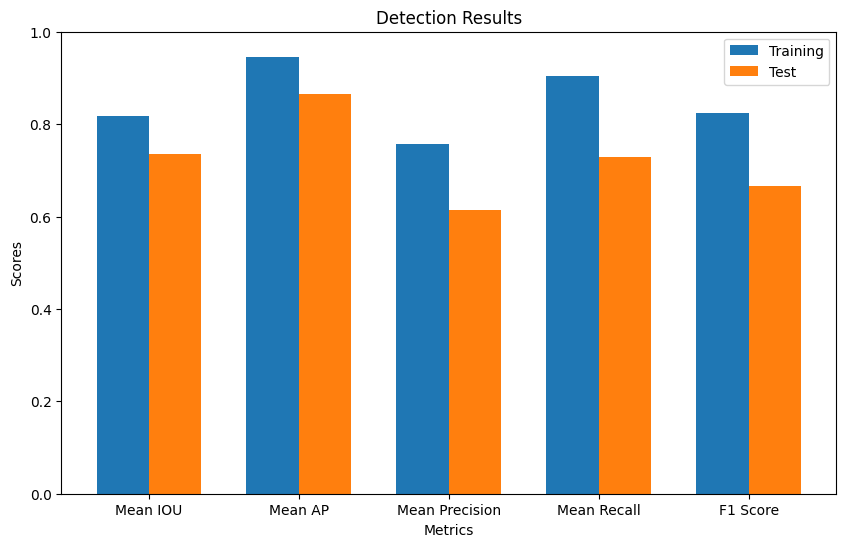

In [24]:
training_detection_results_path = os.path.join('/home/icb/hanyi.zhang/Detection_Head/training_results', 'detection_results.json')
test_detection_results_path = os.path.join('/home/icb/hanyi.zhang/Detection_Head/test_results', 'detection_results.json')

# Loading dictionary from a JSON file
with open(training_detection_results_path, 'r') as json_file:
    training_detection_results_dict = json.load(json_file)

# Loading dictionary from a JSON file
with open(test_detection_results_path, 'r') as json_file:
    test_detection_results_dict = json.load(json_file)

# Call the function to print the results
print('Old results: ')
print('Evaluation Results on Training Dataset:')
print_detection_results(training_detection_results_dict)
print('\nEvaluation Results on Test Dataset:')
print_detection_results(test_detection_results_dict)

# Call the function to plot the results
plot_detection_results(training_detection_results_dict, test_detection_results_dict)

### New results

New results: 
Evaluation Results on Training Dataset:
Average IOU         : 0.8099201256858093
Mean AP             : 0.954231019843739
Mean Precision      : 0.7782155936780827
Mean Recall         : 0.8936517170131649
F1 Score            : 0.8319484411825683

Evaluation Results on Test Dataset:
Average IOU         : 0.7274183822619862
Mean AP             : 0.8607598599513712
Mean Precision      : 0.6081353015051841
Mean Recall         : 0.6787546875103044
F1 Score            : 0.6415073394935983


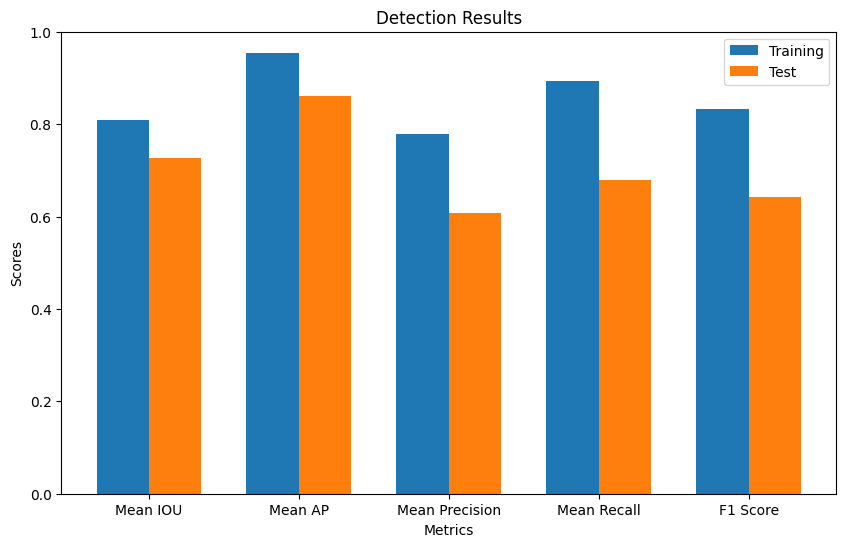

In [4]:
training_detection_results_path = os.path.join('/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png-small/train/overall_evaluation_results', 'detection_results.json')
test_detection_results_path = os.path.join('/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png-small/test/overall_evaluation_results', 'detection_results.json')

# Loading dictionary from a JSON file
with open(training_detection_results_path, 'r') as json_file:
    training_detection_results_dict = json.load(json_file)

# Loading dictionary from a JSON file
with open(test_detection_results_path, 'r') as json_file:
    test_detection_results_dict = json.load(json_file)

# Call the function to print the results
print('New results: ')
print('Evaluation Results on Training Dataset:')
print_detection_results(training_detection_results_dict)
print('\nEvaluation Results on Test Dataset:')
print_detection_results(test_detection_results_dict)

# Call the function to plot the results
plot_detection_results(training_detection_results_dict, test_detection_results_dict)

### Segmentation Results

### Old results

Old results: 
Evaluation Results on Training Dataset:
Mean IOU            : 0.764780425360829
Mean Dice           : 0.85863353840162
Mean Precision      : 0.7137115408099759
Mean Recall         : 0.8525475247164684
F1 Score            : 0.7769761987294284

Evaluation Results on Test Dataset:
Mean IOU            : 0.7236637322188982
Mean Dice           : 0.8288047198630114
Mean Precision      : 0.6047792772112264
Mean Recall         : 0.7192658936779219
F1 Score            : 0.6570729109024321


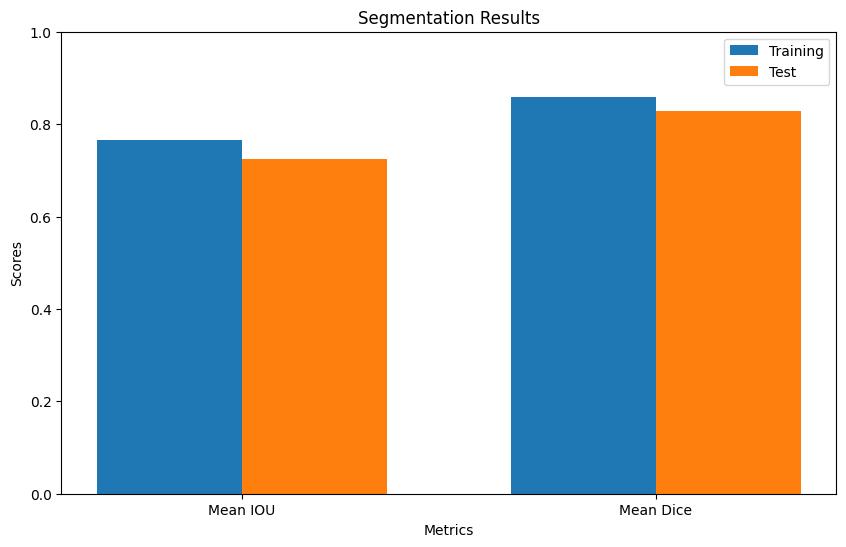

In [19]:
training_segmentation_results_path = os.path.join('/home/icb/hanyi.zhang/Detection_Head/training_results', 'segmentation_results.json')
test_segmention_results_path = os.path.join('/home/icb/hanyi.zhang/Detection_Head/test_results', 'segmentation_results.json')

# Loading dictionary from a JSON file
with open(training_segmentation_results_path, 'r') as json_file:
    training_segmentation_results_dict = json.load(json_file)

# Loading dictionary from a JSON file
with open(test_segmention_results_path, 'r') as json_file:
    test_segmention_results_dict = json.load(json_file)

# Call the function to print the results
print('Old results: ')
print('Evaluation Results on Training Dataset:')
print_segmentation_results(training_segmentation_results_dict)
print('\nEvaluation Results on Test Dataset:')
print_segmentation_results(test_segmention_results_dict)

# Call the function to plot the results
plot_segmentation_results(training_segmentation_results_dict, test_segmention_results_dict)

### New results

New results: 
Evaluation Results on Training Dataset:
Mean IOU            : 0.7408234112857073
Mean Dice           : 0.8431213178611531
Mean Precision      : 0.7082513583523568
Mean Recall         : 0.8124221719271579
F1 Score            : 0.756768754588919

Evaluation Results on Test Dataset:
Mean IOU            : 0.7093610244986247
Mean Dice           : 0.819381621641974
Mean Precision      : 0.5986528423316022
Mean Recall         : 0.670096627476535
F1 Score            : 0.632363220985325


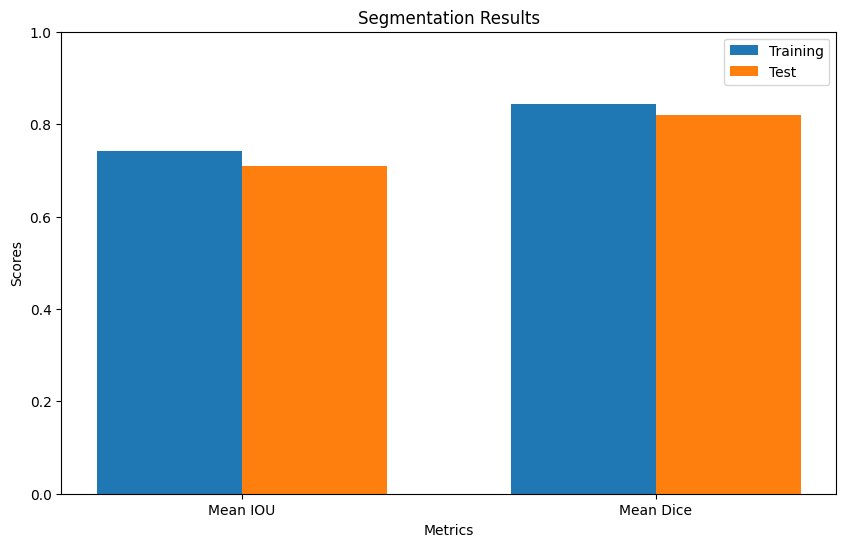

In [20]:
training_segmentation_results_path = os.path.join('/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png-small/train/overall_evaluation_results', 'segmentation_results.json')
test_segmention_results_path = os.path.join('/home/icb/hanyi.zhang/NeurIPS22-CellSeg-png-small/test/overall_evaluation_results', 'segmentation_results.json')

# Loading dictionary from a JSON file
with open(training_segmentation_results_path, 'r') as json_file:
    training_segmentation_results_dict = json.load(json_file)

# Loading dictionary from a JSON file
with open(test_segmention_results_path, 'r') as json_file:
    test_segmention_results_dict = json.load(json_file)

# Call the function to print the results
print('New results: ')
print('Evaluation Results on Training Dataset:')
print_segmentation_results(training_segmentation_results_dict)
print('\nEvaluation Results on Test Dataset:')
print_segmentation_results(test_segmention_results_dict)

# Call the function to plot the results
plot_segmentation_results(training_segmentation_results_dict, test_segmention_results_dict)